# Activity2Class, an end-to-end classifier for accelerometer based HAR classification

## Eeli Susan, Esa Ollila

This notebook contains all the code needed to train and test each of the three demonstrated models, as well as providing an easy structure to train new datasets. The code relies primarily on the following libraries:
* PyTorch
* Numpy
* Pandas

This notebook has the following structure:
1. An old model is loaded if available (and no training is done)
2. Raw accelerometer data is loaded to users RAM and preprocesed (if an old model is loaded, training data is skipped)
3. Preprocessed data is prepared for batches
4. The dataset is visualized
5. The "act2class" model is initialized (and old parameters loaded depending on 1.), and its structure is verified
6. The model is trained (if no old model is used)
7. Results are shown


In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import convolve
sns.set_context("paper", font_scale=1.6)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ['Computer Modern Roman']})

The model and data used here require a GPU as the model has over 200,000 parameters and there are approximately 26,000 training samples. On AMD based GPUs, ROCm is supported by PyTorch [ROCm](https://rocmdocs.amd.com/en/latest/), this is a very recent development (currently in beta), and might cause some unknown issues. In our experimentation, the AMD Vega 64 gives 40% more speed during training.

The script does run if no GPU is available, though training will be extremely slow

In [2]:
# checking of a cuda capable gpu exists, if so use gpu, otherwise use cpu. ROCm based solutions work too using the cuda bindings
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)} ({round(torch.cuda.get_device_properties(0).total_memory/1024**3,1)} GB)")
    print(f"- {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB Allocated")
    print(f"- {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB Reserved")
else:
    device = torch.device("cpu")
    print("Running on CPU")
device = torch.device("cpu")

Running on CPU


## Main parameters

Select wich dataset will be trained/tested or add a new one. The following parameters are needed:
* `L_factor` decides adjusts the depth of the compression. For longer sequences use higher values
* `batch_size` decides how many samples are used simultaneously in a single training iteration. This mostly depends on the speed and VRAM on the GPU. For CPUs, use small values (<32).
* `epochs` number of epochs during training, not used if `skip_train=True`

In [3]:
# choose the dataset and a suitable compression parameter L
# dataset_folder = "../datasets/UCI13_sample"
dataset_folder = "../datasets/SHL18/"
L_factor = 5

batch_size = 64
epochs = 1
if os.path.isdir(dataset_folder):
    print("dataset folder found")
else:
    raise OSError("file not found!")

dataset folder found


## Dataset Structure and loading

All datasets have been modified to follow the same structure. Each dataset MUST have the following:
```
dataset_folder
├──train
│  ├─Acc_x.txt
│  ├─Acc_y.txt
│  ├─Acc_z.txt
│  └─Label.txt
├──test (optional)
│  ├─Acc_x.txt
│  ├─Acc_y.txt
│  ├─Acc_z.txt
│  └─Label.txt
├──validation (optional)
│  ├─Acc_x.txt
│  ├─Acc_y.txt
│  ├─Acc_z.txt
│  └─Label.txt
├──Model (optional)
└──Label_names.txt
```
Each `Acc_?.txt` file contains rows with any length of samples, correspoding to sequences of accelerometer measurements. The `Label.txt` file must contain a label (integer) for each of the rows. Labels must be sequential, but do not have to start from 0 (this is automatically compensated). The `Label_names.txt` file should contain the names of each class in order of the integer labels. For joint classification use names with an underscore (i.e. ``label1_label2``). These are later split during results

If the test and validation folders are missing, the code automatically splits the training set into 50% train, 17% validation, and 33% testing data. If training and testing data is given, training is split into 80% training and 20% validation.

A trained model is stored as `Model` and can be loaded if training is skipped

In [4]:
class DatasetLoader(Dataset):
    # Initialization of the class instance. In this case, all data is loaded and preprocessed
    def __init__(self, directory, kernel_size=120, limit_samples=500000):

        # Loading all data: Acc_x, Acc_y, Acc_z, and labels
        print("Loading labels")#470572
        self.labels = pd.read_csv(os.path.join(directory, "Label.txt"), sep=" ", header=None, names=["Label"], usecols=["Label"], nrows=limit_samples).reset_index(drop=True)
        self.labels["Label"] = self.labels["Label"] - int(self.labels.min())
        print("Loading accelerometer data (this might take a while)")
        self.acc_x = pd.read_csv(os.path.join(directory, "Acc_x.txt"), sep=" ", header=None, nrows=limit_samples).to_numpy()
        print("-x")
        self.acc_y = pd.read_csv(os.path.join(directory, "Acc_y.txt"), sep=" ", header=None, nrows=limit_samples).to_numpy()
        print("-y")
        self.acc_z = pd.read_csv(os.path.join(directory, "Acc_z.txt"), sep=" ", header=None, nrows=limit_samples).to_numpy()
        print("-z")
        # Initializing the mean filter kernel, currently at 150 samples (1.5 seconds)
        filter_kernel = np.ones((1,2*kernel_size+1))/(2*kernel_size+1)
        
        # Initializing the preprocessed arrays: vertical, horizontal and gravity vectors. These all have the shape of ("sequence length", "number of samples").
        self.vertical = np.zeros_like(self.acc_x)
        self.horizontal = np.zeros_like(self.acc_x)
        self.gravity_x = np.zeros_like(self.acc_x)
        self.gravity_y = np.zeros_like(self.acc_x)
        self.gravity_z = np.zeros_like(self.acc_x)
        print("Applying preprocessing to data")
        for sample_index in tqdm(range(self.acc_x.shape[0]), file=sys.stdout):
            # loading each training sequence (N samples)
            sample = np.stack([self.acc_x[sample_index,:],self.acc_y[sample_index,:],self.acc_z[sample_index,:]])
            #print(sample.shape)
            # applying a mean filter to estimate the gravity component
            grav=convolve(sample, filter_kernel, mode='reflect')
            grav_norm = grav/np.linalg.norm(grav,axis=0)
            # removing the mean to estimate the "dynamic" part caused by users movement
            dynamic = sample-grav
            # the vertical component is a projection on the gravity vector
            vertical = (np.sum(dynamic*grav, axis=0)/(np.sum(grav*grav, axis=0)))*grav
            # based on the dot product (angle) we can estimate the direction of the force (up or down)
            vertical_direction = np.sign(np.sum(vertical*grav, axis=0))
            # the horizontal part is the dynamic-vertical, here we calculate the magnitude
            horizontal = np.linalg.norm(dynamic-vertical,axis=0)
            # we solve the magnitude of the vertical component and apply the sign from "vertical_direction"
            vertical = vertical_direction*np.linalg.norm(vertical, axis=0)

            # storing all the variables
            self.vertical[sample_index,:] = vertical
            self.horizontal[sample_index,:] = horizontal
            self.gravity_x[sample_index,:] = grav_norm[0,:]
            self.gravity_y[sample_index,:] = grav_norm[1,:]
            self.gravity_z[sample_index,:] = grav_norm[2,:]
        print(f"Dataset takes approximately {self.acc_x.nbytes*5*1e-9:.1f} GB of storage")
        # clearing raw data to make more space
        self.acc_x = None
        self.acc_y = None
        self.acc_z = None
        print("Done.")

    # The len method returns a value when the len() function is called on a class instance (i.e. len(dataset) returns the length of the dataset)
    def __len__(self):
        return len(self.labels)
    # The getitem method is used when indexing instances of this class (i.e. dataset[0] returns the first sample etc.). Also allows iteration with for loops
    def __getitem__(self,index):
        return self.labels["Label"].iloc[index], [self.vertical[index,:], self.horizontal[index,:], self.gravity_x[index,:], self.gravity_y[index,:], self.gravity_z[index,:]]

The following class `CustomBatch` and `collate_fn` are functions which map single samples from the `DatasetLoader` class to be batched. In practice this class only converts numpy arrays to tensors of the correct data type and stacks them in the correct dimension of `[batch, channel, sequence]`. The `pin_memory` method pins all the samples to RAM in such a way they are quickly accessible to the GPU. if this is not done, the time to load from RAM to vRAM takes a bit longer. 

In [5]:
class CustomBatch:
    def __init__(self, batch):
        label_list, seq_list = zip(*batch)
        label_list = [torch.tensor(int(label), dtype=torch.long) for label in label_list]
        seq_tensors = list()
        for seq in seq_list:

            seq = torch.tensor([seq[0], seq[1], seq[2], seq[3], seq[4]], dtype=torch.float)
            seq_tensors.append(seq)

        self.inp = torch.stack(seq_tensors)
        self.tgt = torch.stack(label_list)

    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_fn(batch):
    return CustomBatch(batch)

Decided if you want to train a new model or load an existing one. Answer `y` to load existing model and skip training.

In [6]:
# a simple function used to ask yes/no questions
question = lambda q: input(q).lower().strip()[0] == "y"
# enable skip training of old model exists
if (os.path.isfile(os.path.join(dataset_folder, "model"))):
    print("pretrained model exists")
    if question("Load model? (y/n)"):
        skip_train=True
    else:
        skip_train=False
else:
    skip_train=False

pretrained model exists


Automatic splitting of train, test and validation data depending on what is available in the folder structure.

In [7]:
num_folders = len(next(os.walk(dataset_folder))[1])
if num_folders==1:
    dataset = DatasetLoader(os.path.join(dataset_folder,"train"))
    dataset_train, dataset_test, dataset_validation = torch.utils.data.random_split(dataset,[int(1/2*len(dataset)), len(dataset) - int(1/2*len(dataset)) - int(1/3*len(dataset)),int(1/3*len(dataset))])
elif num_folders==2:
    if skip_train:
        dataset_test = DatasetLoader(os.path.join(dataset_folder,"test"))
    else:
        dataset = DatasetLoader(os.path.join(dataset_folder,"train"))
        dataset_train, dataset_validation = torch.utils.data.random_split(dataset,[len(dataset) - int(1/6*len(dataset)), int(1/6*len(dataset))])
        dataset_test = DatasetLoader(os.path.join(dataset_folder,"test"))
elif num_folders==3:
    if skip_train:
        dataset_test = DatasetLoader(os.path.join(dataset_folder,"test"))
    else:
        dataset_train = DatasetLoader(os.path.join(dataset_folder,"train"))
        dataset_test = DatasetLoader(os.path.join(dataset_folder,"test"))
        dataset_validation = DatasetLoader(os.path.join(dataset_folder,"validation"))


Loading labels
Loading accelerometer data (this might take a while)
-x
-y
-z
Applying preprocessing to data
100%|██████████| 5698/5698 [00:30<00:00, 189.23it/s]
Dataset takes approximately 1.4 GB of storage
Done.


Batch initialization and loading of class names. The pytorch functions `random_split` and `DataLoader` are used to split the data into training and evaluation samples and then into an interable function which batches the samples into minibatches.

NOTE: There exists an unresolved error with some computers and the multiprocessing module. The fix for this is to change `num_workers=0` and remove the `prefetch_factor` argument.

In [8]:
if skip_train:
    testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=12, prefetch_factor=2)
else:
    trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=12, prefetch_factor=2)
    validationloader = DataLoader(dataset_validation, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=12, prefetch_factor=2)
    testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=12, prefetch_factor=2)

sequence_length = dataset_test[0][1][1].shape[0]
try:
    num_classes = len(dataset_test.labels["Label"].unique())
except AttributeError:
    num_classes = len(dataset.labels["Label"].unique())

class_names = pd.read_csv(os.path.join(dataset_folder, "Label_names.txt"), sep=" ", header=None).transpose().values.tolist()[0]

## Dataset visualized

Below you can see a few samples of each of the classes. Each sample contains 5 channels: horizontal, vertical, and gravity components.

<ipython-input-5-4c76ee2f478b>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  seq = torch.tensor([seq[0], seq[1], seq[2], seq[3], seq[4]], dtype=torch.float)


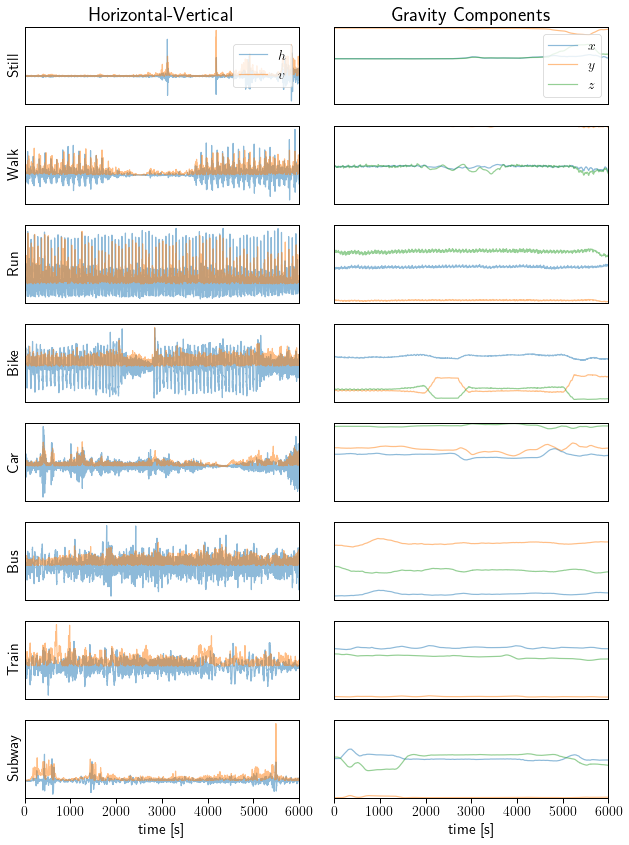

In [9]:
fig, axs = plt.subplots(nrows=num_classes, ncols=2, figsize=(9,12))

axs = axs.ravel(order='F')

for fig_i in range(num_classes):
    class_i = fig_i%num_classes
    while True:
        i = np.random.randint(0,len(dataset_test))
        sample = dataset_test[i]
        #
        #print(list(sample))
        batch = collate_fn([sample])
        seqs = batch.inp
        label = batch.tgt
        #print(seqs)
        seqs = seqs.squeeze()
        if (int(label[0])==class_i):
            break
    axs[fig_i].plot(seqs.permute([1,0])[:,0:2], alpha=0.5)
    axs[fig_i+num_classes].plot(seqs.permute([1,0])[:,2:5], alpha=0.5)
    axs[fig_i+num_classes].set_ylim([-1,1])
    axs[fig_i].set_xlim([0,seqs.shape[1]])
    axs[fig_i+num_classes].set_xlim([0,seqs.shape[1]])
    
    axs[fig_i].set_yticks([])
    axs[fig_i+num_classes].set_yticks([])
    if (fig_i<num_classes):
        axs[fig_i].set_ylabel(class_names[fig_i])
    if (fig_i==0):
        axs[fig_i].set_title("Horizontal-Vertical", fontsize=20)
        axs[fig_i+num_classes].set_title("Gravity Components", fontsize=20)
        axs[fig_i].legend(["$h$","$v$"],loc=5)
        axs[fig_i+num_classes].legend(["$x$","$y$","$z$"],loc=5)
    if (fig_i!=num_classes-1):
        axs[fig_i].set_xticks([])
        axs[fig_i+num_classes].set_xticks([])
    else:
        axs[fig_i].set_xlabel("time [s]")
        #axs[fig_i].set_xticks(np.arange(7000, step=1000))
        #axs[fig_i].set_xticklabels(np.arange(70, step=10))
        axs[fig_i+num_classes].set_xlabel("time [s]")
        #axs[fig_i+num_classes].set_xticks(np.arange(7000, step=1000))
        #axs[fig_i+num_classes].set_xticklabels(np.arange(70, step=10))

plt.tight_layout()
plt.savefig("../figures/sequences_figure.pdf")
plt.show()

## The Model
The following class defines the neural network with each of its layers. In PyTorch, models are defined as children of the parent class ``nn.Module``. The initialization method has to include all of the layers as weights are initialized here. The ``forward`` method is called during traing, it takes the input sequence (in this case ``[batch,layers,length] = [30,2,6000] ``) and returns the output after passing through each of the layers. Below the class is a test instance which tests if the model works for desired input. It also prints the size of the tensor after each layer.

In [10]:
class Attention(nn.Module):
    def __init__(self, device, in_dim, hidden=32):
        super().__init__()
        self.in_dim = in_dim
        self.hidden = hidden
        self.Wt = nn.Parameter(torch.randn(in_dim,hidden)).to(device)
        self.Wx = nn.Parameter(torch.randn(in_dim,hidden)).to(device)
        self.W_2 = nn.Parameter(torch.randn(hidden, 1)).to(device)
        self.b_1 = nn.Parameter(torch.zeros(hidden)).to(device)
        self.b_2 = nn.Parameter(torch.zeros(1)).to(device)
    
    def forward(self, x,debug=False):
        out = x
        if debug: print(f"input \t\t{out.shape}")
        #print(out.shape)
        #print(self.W_1.shape)
        #Ws = self.W_1.T.unsqueeze(0).expand(batch_size,-1,-1)
        #print(Ws.shape)
        
        q = (out@self.Wt).unsqueeze(2)
        k = (out@self.Wx).unsqueeze(1)
        e = torch.tanh(q + k + self.b_1)@self.W_2 + self.b_2
        e = e.squeeze(-1)
        e = torch.exp(e)
        if debug: print(f"similarity \t{e.shape}")
        # add e activation?
        #print(e.shape)
        e_sum = torch.sum(e,dim=-1, keepdims=True)
        alpha = torch.div(e, e_sum)
        if debug: print(f"alphas \t\t{alpha.shape}")
        #print(alpha.shape)
        out = alpha@out
        if debug: print(f"output \t\t{out.shape}")
        #print(out.shape)
        return out, alpha


        
with torch.no_grad():
    print("Attention model summary")
    print("-------------------------------------------------")
    # input is (batch, samples channels)
    #             1       5         3
    test_sample = torch.tensor([[[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]]],dtype=torch.float)
    test_sample = torch.randn((1,3,32),dtype=torch.float)
    test_model = Attention(device=device, in_dim=32)
    test_model.forward(test_sample, debug=True)
    print("-------------------------------------------------")
    model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
    print(f"{sum([np.prod(p.size()) for p in model_parameters])} trainable parameters")

Attention model summary
-------------------------------------------------
input 		torch.Size([1, 3, 32])
similarity 	torch.Size([1, 3, 3])
alphas 		torch.Size([1, 3, 3])
output 		torch.Size([1, 3, 32])
-------------------------------------------------
2113 trainable parameters


In [11]:
class Act2class(nn.Module):
    def __init__(self, device, in_samples=6000, out_classes=8, L_factor=3, lstm_hidden=32):
        super(Act2class, self).__init__()

        # The CNN block, sequential convolution, relu maxpool eight times
        self.compress_1 = nn.Sequential(nn.Conv1d(5,8,8),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(8),
                                      nn.MaxPool1d(2),
                                      nn.Conv1d(8,16,5),
                                      nn.BatchNorm1d(16),
                                      nn.ReLU(),
                                      nn.MaxPool1d(2),
                                      nn.Conv1d(16,32,3),
                                      nn.BatchNorm1d(32),
                                      nn.ReLU(),
                                      nn.MaxPool1d(2))
        
        # L times additional compression
        self.compress_L = nn.ModuleList()
        for i in range(L_factor):
            self.compress_L.append(nn.Sequential(nn.Conv1d(32,32,3), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2)))
                            
        # the RNN
        self.rnn = nn.LSTM(32,lstm_hidden, batch_first=True, bidirectional=True)
        # the attention mechanism
        self.attention = Attention(device, in_dim=lstm_hidden*2, hidden=lstm_hidden*2)
        # the layer normalization used after the summation, similar to "Transformer" paper

        with torch.no_grad():
            test_sample = torch.randn((1,5, in_samples),dtype=torch.float)
            test_sample = self.compress_1(test_sample)
            for compress in self.compress_L:
                test_sample = compress(test_sample)
            test_sample = test_sample.permute([0,2,1])
            test_sample, _ = self.rnn(test_sample)
            tensor_size = int(test_sample.shape[1]*test_sample.shape[2])
        self.norm = nn.LayerNorm(tensor_size)
        # the feedforward network for classification
        self.ff = nn.Sequential(nn.Dropout(0.33),
                                nn.Linear(tensor_size, 256),
                                nn.ReLU(),
                                nn.Dropout(0.45),
                                nn.Linear(256, out_classes))
    def forward(self, sample, debug=False):
        out = sample
        if debug:
            print(f"input \t\t{out.shape}")

        out = self.compress_1(out)
        if debug:
            print(f"compress (ini) \t{out.shape}")

        for i, compress in enumerate(self.compress_L):
            out = compress(out)
            if debug:
                print(f"compress (L={i+1}) \t{out.shape}")


        out = out.permute([0,2,1])
        if debug:
            print(f"flip\t\t{out.shape}")

        out, hidden = self.rnn(out)
        #out = out[:,-1,:]
        if debug:
            print(f"rnn \t\t{out.shape}")
        att, weights = self.attention(out)
        out = att + out
        if debug:
            print(f"attention\t{out.shape}")

        out = out.flatten(start_dim=1)
        if debug:
            print(f"flatten \t{out.shape}")
        out = self.norm(out)

        out = self.ff(out)
        if debug:
            print(f"ff \t\t{out.shape}")
        return out

# no_grad() just disables the calculation of the backwards gradient since it is not used here (we are just testing the shapes)
with torch.no_grad():
    print("Acc2Class model summary")
    print("-------------------------------------------------")
    test_sample = torch.randn((1,5,sequence_length),dtype=torch.float)
    test_model = Act2class(device=device, L_factor=L_factor, out_classes=num_classes, in_samples=sequence_length)
    test_model.forward(test_sample, debug=True)
    print("-------------------------------------------------")
    model_parameters = filter(lambda p: p.requires_grad, test_model.parameters())
    print(f"{sum([np.prod(p.size()) for p in model_parameters])} trainable parameters")

Acc2Class model summary
-------------------------------------------------
input 		torch.Size([1, 5, 6000])
compress (ini) 	torch.Size([1, 32, 747])
compress (L=1) 	torch.Size([1, 32, 372])
compress (L=2) 	torch.Size([1, 32, 185])
compress (L=3) 	torch.Size([1, 32, 91])
compress (L=4) 	torch.Size([1, 32, 44])
compress (L=5) 	torch.Size([1, 32, 21])
flip		torch.Size([1, 21, 32])
rnn 		torch.Size([1, 21, 64])
attention	torch.Size([1, 21, 64])
flatten 	torch.Size([1, 1344])
ff 		torch.Size([1, 8])
-------------------------------------------------
392785 trainable parameters


## Training Loop
The training loop in PyTorch has to always be done by hand. This is a bit more work but much more flexible. First, the model is loaded to the GPU and the optimizer and criterion are defined. We use ``CrossEntropyLoss`` as it allows to omit the softmax layer in the model definition. Second, the loop goes through each epoch and each sample storing the loss and accuracy for each sample.

In [12]:
# defining the model and uploading to GPU (if available)
model = Act2class(device=device, L_factor=L_factor, out_classes=num_classes, in_samples=sequence_length).to(device)

In [13]:

if not skip_train:
    # creating storage for accuracy and loss vectors
    train_acc_results = np.zeros(epochs)
    validation_acc_results = np.zeros(epochs)
    train_loss_results = np.zeros(epochs)
    validation_loss_results = np.zeros(epochs)
    # Choosing the optimizer and giving it all the trainable parameters from the model instance. ADAM is much faster than SGD but theoretically converges to a worse solution
    optimizer = torch.optim.Adam(model.parameters())
    # The criterion used for loss. Since no softmax is used we use cross entropy instead of NLL
    criterion = nn.CrossEntropyLoss()

    # for each epoch
    for epoch in range(epochs):
        # initializing the progress bar
        tqdm_bar = tqdm(enumerate(trainloader), total=len(trainloader))
        # resetting the correct and loss counters
        running_correct = 0
        running_loss = 0
        # switching to training mode such that parameters are actually updated
        model.train()
        #for each batch in the TRAIN set
        for index,  batch in tqdm_bar:
            # pushing the batch to the GPU
            sequences, labels = batch.inp.to(device), batch.tgt.to(device)
            # resetting the gradients
            model.zero_grad()
            # passing the batch through the model
            pred = model(sequences)
            # checking the prediction (used only for the running correct)
            _, predi = pred.topk(1)
            # if same as the label add it to the running sum
            running_correct += (torch.sum(predi.flatten() == labels))
            # loss using cross entropy
            loss = criterion(pred,labels)
            # adding it to the running loss counter, .item() detaches the gradient and relation to the model
            running_loss += loss.item()
            # backpropagation using the loss and gradient
            loss.backward()
            # taking a step using the optimizer (in this case ADAM)
            optimizer.step()
            # updating the progress bar running correct and loss
            tqdm_bar.set_description(f"TRAIN | epoch: {epoch+1:2}, acc: {running_correct/((index+1)*batch_size):.2f}, loss: {running_loss/((index+1)*batch_size):.2f}, progress")
        # storing the running results to the vector
        train_acc_results[epoch] = running_correct/((index+1)*batch_size)
        train_loss_results[epoch] = running_loss/((index+1)*batch_size)
        # setting the model to evaluation mode (i.e weights will not be updated)
        model.eval()
        # resetting counters
        running_correct = 0
        running_loss = 0
        # disabling gradient calculations for performance
        with torch.no_grad():
            # initializing progress bar for the EVAL dataset
            tqdm_bar = tqdm(enumerate(validationloader), total=len(validationloader))
            # for each batch in the EVAL set
            for index,  batch in tqdm_bar:
                # the rest of this loop is identical to above except no learning is done
                sequences, labels = batch.inp.to(device), batch.tgt.to(device)
                pred = model(sequences)
                _, predi = pred.topk(1)
                running_correct += (torch.sum(predi.flatten() == labels))
                loss = criterion(pred,labels)
                running_loss += loss.item()  
                tqdm_bar.set_description(f"EVAL  | epoch: {epoch+1:2}, acc: {running_correct/((index+1)*batch_size):.2f}, loss: {running_loss/((index+1)*batch_size):.2f}, progress")
        # storing results 
        validation_acc_results[epoch] = running_correct/((index+1)*batch_size)
        validation_loss_results[epoch] = running_loss/((index+1)*batch_size)
else:
    model.load_state_dict(torch.load(os.path.join(dataset_folder,"model")))
    print("previous model loaded")

previous model loaded


# 

If something is trained, it can be saved here.

In [14]:
if not skip_train:
    if question("Overwrite existing model? (y/n)"):
        torch.save(model.state_dict(), os.path.join(dataset_folder,"model"))
        np.save(os.path.join(dataset_folder,"train_loss_results.npy"), train_loss_results)
        np.save(os.path.join(dataset_folder,"train_acc_results.npy"), train_acc_results)
        print("Done!")

If something is trained, loss and accuracy curves over epochs are shown here

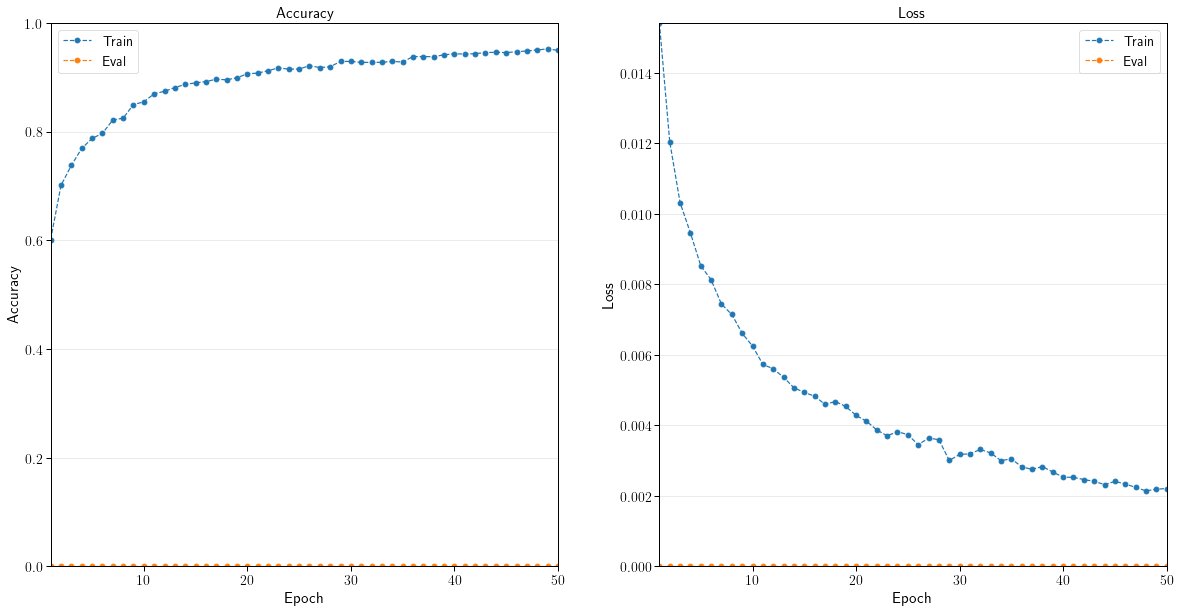

In [15]:
if skip_train:
    train_loss_results = np.load(os.path.join(dataset_folder,"train_loss_results.npy"))
    train_acc_results = np.load(os.path.join(dataset_folder,"train_acc_results.npy"))
    validation_acc_results = np.zeros_like(train_acc_results)
    validation_loss_results = np.zeros_like(train_loss_results)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axs[0].plot(np.arange(1,len(train_acc_results)+1), train_acc_results, '--o')
axs[0].plot(np.arange(1,len(validation_acc_results)+1), validation_acc_results, '--o')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend(["Train", "Eval"])
axs[0].grid(axis="y", alpha=0.3)
axs[0].set_xlim([1,len(train_acc_results)])
axs[0].set_ylim([np.clip(np.min([train_acc_results, validation_acc_results]),0,1), 1])
axs[0].set_title("Accuracy")
axs[1].plot(np.arange(1,len(train_acc_results)+1), train_loss_results, '--o')
axs[1].plot(np.arange(1,len(train_acc_results)+1), validation_loss_results, '--o')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(["Train", "Eval"])
axs[1].grid(axis="y", alpha=0.3)
axs[1].set_xlim([1,len(train_acc_results)])
axs[1].set_ylim([0,np.max([train_loss_results, validation_loss_results])])
axs[1].set_title("Loss")
plt.show()

## Results
Creation of confusion matrices

In [16]:
if skip_train:
    conf_mat_test = np.zeros((num_classes,num_classes), dtype=int)
else:
    conf_mat_train = np.zeros((num_classes,num_classes), dtype=int)
    conf_mat_eval = np.zeros((num_classes,num_classes), dtype=int)
    conf_mat_test = np.zeros((num_classes,num_classes), dtype=int)
with torch.no_grad():
    model.eval()
    if skip_train:
        tqdm_bar = tqdm(enumerate(testloader), total=len(testloader))
        for index, batch in tqdm_bar:
            sequences, labels = batch.inp.to(device), batch.tgt.to(device)
            pred = model(sequences)
            _, predi = pred.topk(1)
            for (pred, label) in zip(predi, labels):
                conf_mat_test[pred,label] +=1
    else:
        tqdm_bar = tqdm(enumerate(trainloader), total=len(trainloader))
        for index, batch in tqdm_bar:
            sequences, labels = batch.inp.to(device), batch.tgt.to(device)
            pred = model(sequences)
            _, predi = pred.topk(1)
            for (pred, label) in zip(predi, labels):
                conf_mat_train[pred,label] +=1

        tqdm_bar = tqdm(enumerate(validationloader), total=len(validationloader))
        for index, batch in tqdm_bar:
            sequences, labels = batch.inp.to(device), batch.tgt.to(device)
            pred = model(sequences)
            _, predi = pred.topk(1)
            for (pred, label) in zip(predi, labels):
                conf_mat_eval[pred,label] +=1

        tqdm_bar = tqdm(enumerate(testloader), total=len(testloader))
        for index, batch in tqdm_bar:
            sequences, labels = batch.inp.to(device), batch.tgt.to(device)
            pred = model(sequences)
            _, predi = pred.topk(1)
            for (pred, label) in zip(predi, labels):
                conf_mat_test[pred,label] +=1


100%|██████████| 90/90 [00:07<00:00, 12.11it/s]


Plotting of confusion matrices

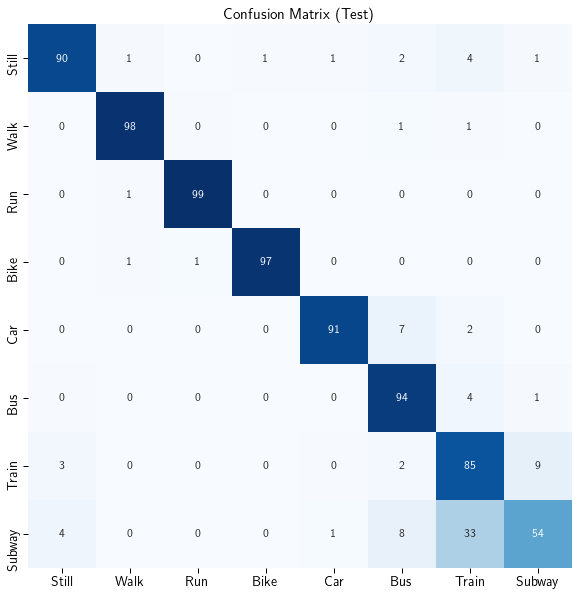

In [17]:
if skip_train:
    conf_mat_test = pd.DataFrame(conf_mat_test, index=class_names, columns=class_names)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10)) 
    axs.set_title("Confusion Matrix (Test)")
    sns.heatmap(conf_mat_test/conf_mat_test.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True,  square=True, annot_kws={"fontsize":12}, fmt=".0f", cmap="Blues", cbar=False, ax=axs)
    plt.show()
else:
    conf_mat_train = pd.DataFrame(conf_mat_train, index=class_names, columns=class_names)
    conf_mat_eval = pd.DataFrame(conf_mat_eval, index=class_names, columns=class_names)
    conf_mat_test = pd.DataFrame(conf_mat_test, index=class_names, columns=class_names)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10)) 
    axs[0].set_title("Confusion Matrix (Train)")
    sns.heatmap(conf_mat_train/conf_mat_train.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True, square=True, annot_kws={"fontsize":12}, fmt=".0f", cmap="Blues", cbar=False, ax=axs[0])
    axs[1].set_title("Confusion Matrix (Eval)")
    sns.heatmap(conf_mat_eval/conf_mat_eval.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True, square=True, annot_kws={"fontsize":12}, fmt=".0f", cmap="Blues", cbar=False, ax=axs[1])
    axs[2].set_title("Confusion Matrix (Test)")
    sns.heatmap(conf_mat_test/conf_mat_test.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True, square=True, annot_kws={"fontsize":12}, fmt=".0f", cmap="Blues", cbar=False, ax=axs[2])
    plt.show()
    #print(np.round(conf_mat_test/conf_mat_test.to_numpy().sum(axis=1).reshape((-1, 1))*100,1))

Simple function to calculate the main metrics used

In [18]:
def getMetrics(conf_mat):
    tp = np.diag(conf_mat.to_numpy()).sum()
    fp = np.tril(conf_mat.to_numpy(), -1).sum()
    fn = np.triu(conf_mat.to_numpy(), 1).sum()

    print("=====================")
    print(f"Train data\t{np.sum(conf_mat.to_numpy())}")
    print(f"True pos:\t{tp}")
    print(f"False pos:\t{fp}")
    print(f"False neg:\t{fn}")
    print("")

    print(f"Accuracy:\t{tp/(np.sum(conf_mat.to_numpy()))*100:.1f}%")
    print(f"Precision:\t{tp/(tp + fn)*100:.1f}%")
    print(f"Recall:\t\t{tp/(tp + fp)*100:.1f}%")
    print(f"F1-score:\t{tp/(tp + 0.5*(fp + fn))*100:.1f}%")

If a joint classification task is done, confusion matrices of the separate labels are split here

In [19]:
if all(["_" in x for x in class_names]):
    print("joint classification matrices possible")
    labels_1 = list(set([x.split("_")[0] for x in class_names]))
    labels_2 = list(set([x.split("_")[1] for x in class_names]))
    conf_labels = conf_mat_test.columns.tolist()
    conf_mat_1 = pd.DataFrame(0, index=labels_1, columns=labels_1)
    conf_mat_2 = pd.DataFrame(0, index=labels_2, columns=labels_2)
    for label_true in labels_1:
        for label_pred in labels_1:
            mask_true = [label_true in x for x in conf_labels]
            mask_pred = [label_pred in x for x in conf_labels]
            conf_mat_1[label_true][label_pred] = (np.sum(conf_mat_test.loc[mask_true,mask_pred].values))
    for label_true in labels_2:
        for label_pred in labels_2:
            mask_true = [label_true in x for x in conf_labels]
            mask_pred = [label_pred in x for x in conf_labels]
            conf_mat_2[label_true][label_pred] = (np.sum(conf_mat_test.loc[mask_true,mask_pred].values))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,18)) 
    axs[0].set_title("Confusion Matrix (Test)")
    sns.heatmap(conf_mat_1/conf_mat_1.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True, annot_kws={"fontsize":12}, fmt=".1f", cmap="Blues", cbar=False, ax=axs[0], square=True)
    axs[1].set_title("Confusion Matrix (Test)")
    sns.heatmap(conf_mat_2/conf_mat_2.to_numpy().sum(axis=1).reshape((-1, 1))*100, annot=True, annot_kws={"fontsize":12}, fmt=".1f", cmap="Blues", cbar=False, ax=axs[1], square=True)
    plt.show()
    #print(np.round(conf_mat_2/conf_mat_2.to_numpy().sum(axis=1).reshape((-1, 1))*100),1)
    getMetrics(conf_mat_1)
    getMetrics(conf_mat_2)
else:
    print("joint classification matrices NOT possible")


joint classification matrices NOT possible


Main results

In [20]:
if not skip_train:
    getMetrics(conf_mat_train)
    #getMetrics(conf_mat_eval)
getMetrics(conf_mat_test)

Train data	5698
True pos:	5097
False pos:	282
False neg:	319

Accuracy:	89.5%
Precision:	94.1%
Recall:		94.8%
F1-score:	94.4%


In [21]:
arr = (conf_mat_test/conf_mat_test.to_numpy().sum(axis=1).reshape((-1, 1))*100).to_numpy()
for i,row in enumerate(arr):
    print(f"$S_{i+1}$ ",end="")
    for elem in row:
        print(f"& {elem:3.1f} ",end="")
    print("\\\\\\hline")

$S_1$ & 90.0 & 1.2 & 0.1 & 0.6 & 0.7 & 2.4 & 3.9 & 1.2 \\\hline
$S_2$ & 0.0 & 97.9 & 0.4 & 0.1 & 0.0 & 0.8 & 0.6 & 0.1 \\\hline
$S_3$ & 0.0 & 0.6 & 99.1 & 0.0 & 0.0 & 0.3 & 0.0 & 0.0 \\\hline
$S_4$ & 0.4 & 0.6 & 1.0 & 97.5 & 0.0 & 0.2 & 0.4 & 0.0 \\\hline
$S_5$ & 0.3 & 0.1 & 0.0 & 0.1 & 90.7 & 6.5 & 2.2 & 0.1 \\\hline
$S_6$ & 0.4 & 0.3 & 0.0 & 0.0 & 0.3 & 94.3 & 3.6 & 1.2 \\\hline
$S_7$ & 3.1 & 0.2 & 0.0 & 0.0 & 0.4 & 2.2 & 85.3 & 8.7 \\\hline
$S_8$ & 4.4 & 0.0 & 0.0 & 0.2 & 0.8 & 7.6 & 32.8 & 54.1 \\\hline
